In [4]:
from openbci_stream.consumer import OpenBCIConsumer
from openbci_stream.acquisition import Cyton
from openbci_stream.acquisition import CytonConstants as cnt

from openbci_stream.preprocess.eeg_filters import GenericButterBand, notch60
from openbci_stream.preprocess.eeg_features import welch, spectrum

from matplotlib import pyplot as plt
import numpy as np
import time

from gcpds.utils.visualizations import plot_eeg

# import logging
# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger('kafka').setLevel(logging.ERROR)
# logging.getLogger('matplotlib').setLevel(logging.ERROR)

def show(data):
    plt.figure(figsize=(16, 5), dpi=90)

    plt.subplot(121)
    [plt.plot(ch+(i*1e6)-ch.mean()) for (i, ch) in enumerate(data)]
    if len(data)>1:
        plt.yticks(np.arange(len(data))*1e6, [f'ch{ch+1}' for ch in range(len(data))])
    else:
        plt.ylabel('$\mu V$')
    plt.xlim(0, 250)
    plt.xlabel('samples')

    plt.subplot(122)
    # w, Y = welch(data, fs=250, axis=1)
    w, Y = spectrum(data, fs=250, axis=1)
    [plt.plot(w, y) for y in Y]
    plt.xlim(0, 60)
    plt.xlabel('Frequency [Hz]')

# Appendix 1 - Measuring Electrode Impedance

The measuring of impedance in the `ADS1299` is made it by injecting a `6nA` altern current at `31.2 Hz`, in this example we will measure the impedande in the `N` inputs, and will use the `leadoff_impedance` method to set these inputs in the correct mode.

The first step is to connect correctly the Cyton board to replicate this experiment, I will use a `10K` potentiometer to connected between the `N` input (bottom) of channel 1 and the `SRB2` (bottom), we will not use the `BIAS` pin in this guide, if you want to test with your head instead of a potentiometer then you must use this pin.

## Offline measurement

In [5]:
openbci = Cyton('serial', '/dev/ttyUSB5', capture_stream=True, daisy=False)
openbci.command(cnt.DEFAULT_CHANNELS_SETTINGS)
openbci.leadoff_impedance(range(1, 9), pchan=cnt.TEST_SIGNAL_NOT_APPLIED, nchan=cnt.TEST_SIGNAL_APPLIED)

openbci.stream(10)
data_raw = openbci.eeg_time_series

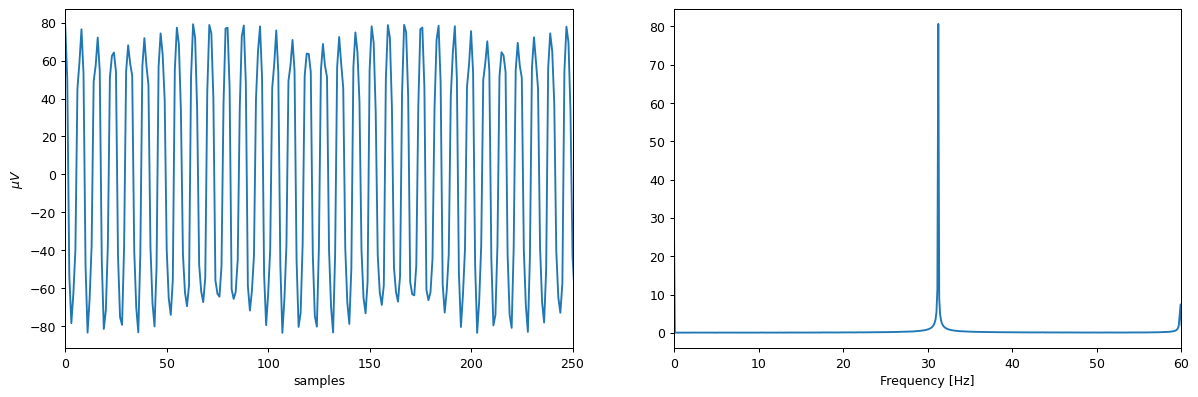

In [6]:
show([data_raw[0]])

This is not what we must see here, we need to have a "perfect" sinusoidal at `31.2 Hz`, maybe by filtering:

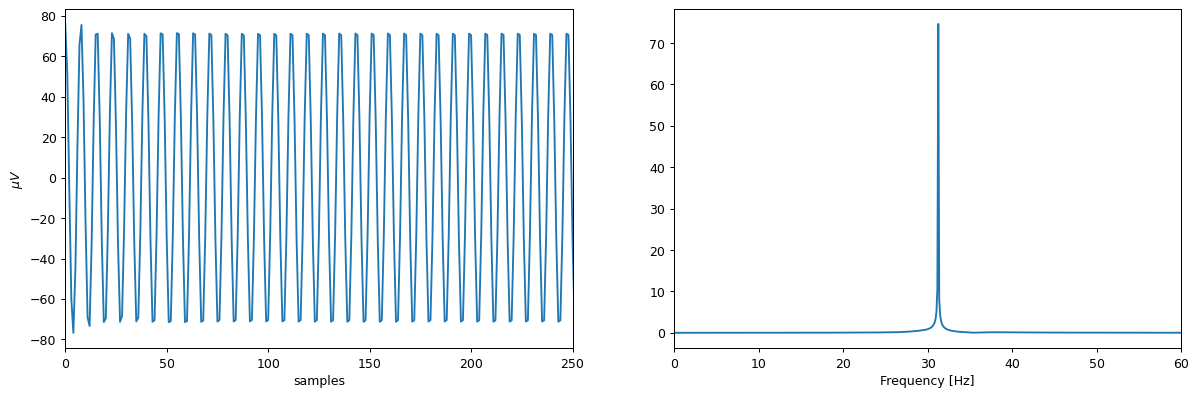

In [7]:
band_2737 = GenericButterBand(27, 37, fs=250)

def filter_impedance(v):
    v = notch60(v, fs=250)
    return band_2737(v, fs=250)

data = filter_impedance(data_raw)
    
show([data[0]])

Now we need the `RMS` voltage, there is a lot of formulas to get this value, even using the `std`, but I like to use one based on the `VPP`:

$$
V_{RMS}=\frac{V_{pp}}{2\sqrt{2}}
$$

Our `Vpp` can be calculated as the *maximun* - *minimum*

In [11]:
def get_rms(v):
    return (v.max()-v.min())/(2*np.sqrt(2))

rms = get_rms(data[0])
rms

54.00012802801145

$$
Z=\frac{V_{RMS}}{I_{RMS}}
$$

We know that the `ADS1299` injects a `6nA` of alternating current, so:

$$
I_{RMS}=\frac{6nA}{\sqrt{2}}
$$

Then, considering that we have `uV` instaead of `V`:

$$
Z=\frac{\mu V_{RMS}\cdot10^{-6}\cdot\sqrt{2}}{6\cdot10^{-9}}
$$

In [13]:
def get_z(v):
    rms = get_rms(v)
    return 1e-6 * rms * np.sqrt(2) / 6e-9

z = get_z(data[0])
print(f'For {rms:.2f} uVrms the electrode impedance is {z/1000:.2f} KOhm')

For 54.00 uVrms the electrode impedance is 12.73 KOhm


The Cyton board has a 2.2K Ohm resistors in series with each electrode, so we must remove this value in way to get the real one.

In [14]:
def get_z(v):
    rms = get_rms(v)
    z = (1e-6 * rms * np.sqrt(2) / 6e-9) - 2200
    if z < 0:
        return 0
    return z

z = get_z(data[0])
print(f'For {rms:.2f} uVrms the electrode-to-head impedance is {(z)/1000:.2f} KOhm')

For 54.00 uVrms the electrode-to-head impedance is 10.53 KOhm


## Real time measurement

For this experiment we will use the Kafka consumer interface, and the same potentiometer.

In [17]:
Z = []
with OpenBCIConsumer('serial', '/dev/ttyUSB5', host='localhost', stream_samples=250, daisy=False) as (stream, openbci):
    
    openbci.stop_stream()
    openbci.command(cnt.DEFAULT_CHANNELS_SETTINGS)
    openbci.leadoff_impedance(range(1, 9), pchan=cnt.TEST_SIGNAL_NOT_APPLIED, nchan=cnt.TEST_SIGNAL_APPLIED)
    openbci.start_stream()
    
    for i, message in enumerate(stream):
        if message.topic == 'eeg':
        
            eeg, aux = message.value['data']
            eeg = filter_impedance(eeg)
            z = get_z(eeg[0])
            Z.append(z)
            
            print(f'{z/1000:.2f} kOhm')
            if i > 20:
                break

11.08 kOhm
14.34 kOhm
11.51 kOhm
12.64 kOhm
9.60 kOhm
7.59 kOhm
10.69 kOhm
5.77 kOhm
4.50 kOhm
3.81 kOhm
3.03 kOhm
4.75 kOhm
7.34 kOhm
7.99 kOhm
12.34 kOhm
12.48 kOhm
11.43 kOhm
10.94 kOhm
6.73 kOhm
9.06 kOhm
4.44 kOhm
2.99 kOhm


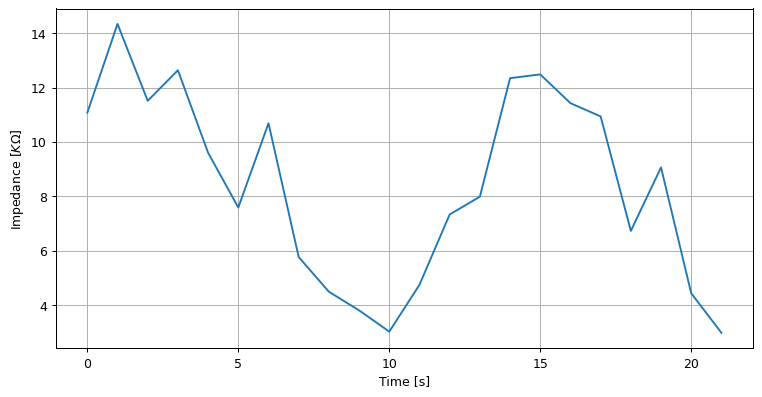

In [18]:
plt.figure(figsize=(10, 5), dpi=90)
plt.plot(np.array(Z)/1000)
plt.ylabel('Impedance [$K\Omega$]')
plt.xlabel('Time [s]')
plt.grid(True)
plt.show()